In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Disable GPU

import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import optax
import jaxopt

import matplotlib.pyplot as plt

from gpax.core import Parameter
from gpax.models import ExactGPRegression
from gpax.kernels import RBF
from gpax.means import Scalar, Average
from gpax.likelihoods import Gaussian
from gpax.utils import train_fn
from gpax.plotting import plot_posterior

import pprint
pp = pprint.PrettyPrinter(depth=4)

is_parameter = lambda x: isinstance(x, Parameter)

2022-12-16 03:41:04.101837: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


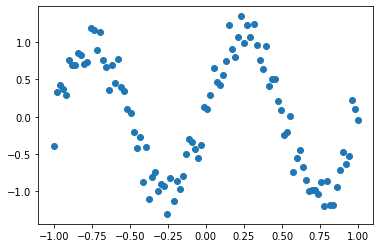

In [2]:
X = jnp.linspace(-1, 1, 100).reshape(-1, 1)
key = jax.random.PRNGKey(0)
y = jnp.sin(2 * jnp.pi * X) + jax.random.normal(key, X.shape)*0.2
y = y.ravel()

plt.scatter(X, y);

## Exact GP

In [7]:
model = ExactGPRegression(kernel=RBF(X), likelihood=Gaussian(), mean=Scalar())

init_key = jax.random.PRNGKey(0)
raw_params = model.initialize(init_key)

In [8]:
raw_params

{'kernel': {'lengthscale': DeviceArray([0.30984825], dtype=float32),
  'scale': DeviceArray(-1.3642794, dtype=float32)},
 'likelihood': {'scale': DeviceArray(2.2861156, dtype=float32)},
 'mean': {'value': DeviceArray(0.6714109, dtype=float32)}}

In [9]:
model.get_parameters()

{'kernel': {'lengthscale': DeviceArray([0.8600244], dtype=float32),
  'scale': DeviceArray(0.2275855, dtype=float32)},
 'likelihood': {'scale': DeviceArray(2.3829343, dtype=float32)},
 'mean': {'value': DeviceArray(0.6714109, dtype=float32)}}

In [10]:
params = model.get_parameters()
pp.pprint(params)

{'kernel': {'lengthscale': DeviceArray([0.8600244], dtype=float32),
            'scale': DeviceArray(0.2275855, dtype=float32)},
 'likelihood': {'scale': DeviceArray(2.3829343, dtype=float32)},
 'mean': {'value': DeviceArray(0.6714109, dtype=float32)}}


In [11]:
params_objects = model.get_parameters(raw_dict=False)
bijectors = jtu.tree_map(lambda x: type(x.bijector).__name__, params_objects, is_leaf=is_parameter)
pp.pprint(bijectors)

{'kernel': {'lengthscale': 'Softplus', 'scale': 'Softplus'},
 'likelihood': {'scale': 'Softplus'},
 'mean': {'value': 'Identity'}}


In [44]:
def loss_fun(raw_params):
    model.set_raw_parameters(raw_params)
    return -model.log_probability(X, y)

jax.grad(loss_fun)(raw_params)

{'kernel': {'lengthscale': DeviceArray([300.9536], dtype=float32),
  'scale': DeviceArray(-496.1765, dtype=float32)},
 'likelihood': {'scale': DeviceArray(-199.25682, dtype=float32)},
 'mean': {'value': DeviceArray(-218.15541, dtype=float32)}}

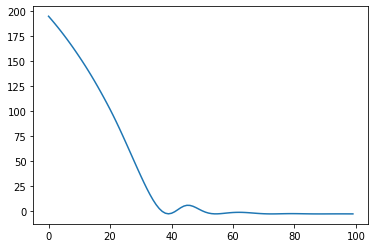

In [46]:
optimizer = optax.adam(learning_rate=0.1)
n_iters = 100

init_key = jax.random.PRNGKey(42)
raw_params = model.initialize(init_key)

result = train_fn(loss_fun, raw_params, optimizer, n_iters=n_iters)

plt.plot(result["loss_history"]);

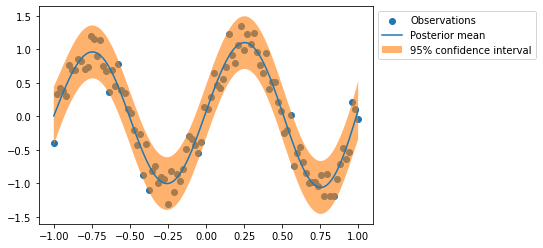

In [47]:
X_test = jnp.linspace(-1, 1, 200).reshape(-1, 1)
model.set_raw_parameters(result["raw_params"])
pred_mean, pred_cov = model.predict(X, y, X_test)

ax = plot_posterior(X, y, X_test, pred_mean, pred_cov, ax=None, alpha=0.6);
ax.legend(bbox_to_anchor=(1,1));

## Sparse GP (Deprecated)

In [8]:
X_inducing = X[40:50]
model = SparseGP(
    kernel=RBFKernel(),
    noise=HomoscedasticNoise(),
    mean=ConstantMean(),
    method="vfe", # "vfe" or "fitc" or "dtc"
)


def loss_fun(params):
    return -model.elbo(params, X, y)

key = jax.random.PRNGKey(123)
params = model.initialize_params(key, X, X_inducing)
bijectors = model.get_bijectors()

optimizer = optax.adam(1e-1)
num_epochs = 100

params = unconstrain(params, bijectors)
params = randomize(params, key)
result = train_fn(loss_fun, params, bijectors, optimizer, num_epochs=num_epochs)

plt.plot(result["loss_history"]);

NameError: name 'SparseGP' is not defined

In [ ]:
params = constrain(result["params"], bijectors)
ax = plot_posterior(model, params, X, y, X_test, ax=None, alpha=0.6)
f = model.get_gp(params)
pseudo_obs = model.get_pseudo_obs(params, f, X, y)
ax.plot(params['X_inducing'], B.dense(pseudo_obs.mu(f.measure)), 'o', color='red', label='pseudo obs');
ax.legend(bbox_to_anchor=(1,1));